# Goal with this notebook is to figure out how to make the dictionaries for novel

In [1]:
import pandas as pd
import numpy as np
import ast
from pathlib import Path
import multirecording_spikeanalysis as spike

In [2]:
cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

In [3]:
# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [4]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'recordings' / 'updated_phys' / 'novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs1-2and2-2_merged.rec
<class 'numpy.ndarray'>
20230628_111202_standard_comp_to_novel_agent_D1_subj_1-2vs1-1and2-1_merged.rec
<class 'numpy.ndarray'>
20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1v1-4and2-1_merged.rec
<class 'numpy.ndarray'>
20230629_111937_standard_comp_to_novel_agent_D2_subj_1-4vs1-1and2-2_merged.rec
<class 'numpy.ndarray'>
20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs1-2and2-1_merged_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject


In [5]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

In [6]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 1, ignore_freq = 0.5)

These recordings are missing event dictionaries:
['20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs1-2and2-2_merged.rec', '20230628_111202_standard_comp_to_novel_agent_D1_subj_1-2vs1-1and2-1_merged.rec', '20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1v1-4and2-1_merged.rec', '20230629_111937_standard_comp_to_novel_agent_D2_subj_1-4vs1-1and2-2_merged.rec', '20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs1-2and2-1_merged_merged.rec']
These recordings are missing subjects: ['20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs1-2and2-2_merged.rec', '20230628_111202_standard_comp_to_novel_agent_D1_subj_1-2vs1-1and2-1_merged.rec', '20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1v1-4and2-1_merged.rec', '20230629_111937_standard_comp_to_novel_agent_D2_subj_1-4vs1-1and2-2_merged.rec', '20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs1-2and2-1_merged_merged.rec']


In [9]:
import ast
from pathlib import Path

import multirecording_spikeanalysis as spike
import numpy as np
import pandas as pd

cols = [
    "condition ",
    "session_dir",
    "all_subjects",
    "tone_start_timestamp",
    "tone_stop_timestamp",
]

# Load the data
df = pd.read_excel(
    "rce_pilot_2_per_video_trial_labels.xlsx", usecols=cols, engine="openpyxl"
)

df2 = df.dropna()  # Drop the rows missing data
df3 = df2.copy()
df3["all_subjects"] = df3["all_subjects"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)  # Make the 'all_subjects' column readable as a list

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df3.iterrows():
    session_dir = row["session_dir"]
    subjects = row["all_subjects"]
    condition = row["condition "]

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split("_subj_")[0]

    for subject in subjects:
        subject_formatted = subject.replace(".", "-")
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append(
            {
                "session_dir": session_dir,
                "subject": subject,
                "subj_recording": subj_recording,
                "condition": (
                    condition
                    if condition in ["rewarded", "omission", "both_rewarded", "tie"]
                    else ("win" if str(condition) == str(subject) else "lose")
                ),
                "tone_start_timestamp": row["tone_start_timestamp"],
                "tone_stop_timestamp": row["tone_stop_timestamp"],
            }
        )

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row["subj_recording"]
    condition = row["condition"]
    timestamp_start = int(row["tone_start_timestamp"]) // 20
    timestamp_end = int(row["tone_stop_timestamp"]) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {
            cond: []
            for cond in ["rewarded", "win", "lose", "omission", "both_rewarded", "tie"]
        }
    if condition not in timestamp_dicts[key]:
        timestamp_dicts[key][condition] = []
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(
            timestamp_dicts[subj_recording][condition], dtype=np.int64
        )

# Handle novel sessions with more than 2 subjects
novel_sessions = df3[df3["all_subjects"].apply(lambda x: len(x) >= 3)]
novel_dicts = {}
for _, row in novel_sessions.iterrows():
    session_dir = row["session_dir"]
    subjects = row["all_subjects"]
    condition = row["condition "]

    base_session_dir = session_dir.split("_subj_")[0]
    for subject in subjects:
        subject_formatted = subject.replace(".", "-")
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        key = f"{subj_recording}_novel"
        timestamp_start = int(row["tone_start_timestamp"]) // 20
        timestamp_end = int(row["tone_stop_timestamp"]) // 20
        tuple_val = (timestamp_start, timestamp_end)

        if key not in novel_dicts:
            novel_dicts[key] = {
                cond: []
                for cond in [
                    "rewarded",
                    "win",
                    "lose",
                    "omission",
                    "both_rewarded",
                    "tie",
                ]
            }
        if condition not in novel_dicts[key]:
            novel_dicts[key][condition] = []
        novel_dicts[key][condition].append(tuple_val)

# Convert lists in novel_dicts to numpy arrays
for subj_recording in novel_dicts:
    for condition in novel_dicts[subj_recording]:
        novel_dicts[subj_recording][condition] = np.array(
            novel_dicts[subj_recording][condition], dtype=np.int64
        )

# Combine regular and novel dictionaries
timestamp_dicts.update(novel_dicts)

In [10]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path(".") / "recordings" / "updated_phys" / "novel"

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs1-2and2-2_merged.rec
<class 'numpy.ndarray'>
20230628_111202_standard_comp_to_novel_agent_D1_subj_1-2vs1-1and2-1_merged.rec
<class 'numpy.ndarray'>
20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1v1-4and2-1_merged.rec
<class 'numpy.ndarray'>
20230629_111937_standard_comp_to_novel_agent_D2_subj_1-4vs1-1and2-2_merged.rec
<class 'numpy.ndarray'>
20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs1-2and2-1_merged_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject


In [11]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find("subj_")
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len("subj_") + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[
            recording_key_without_suffix
        ]

        # Extract the subject from the recording key
        start = recording.find("subj_") + 5  # Start index after 'subj_'
        subject = recording[start : start + 3]

        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

In [12]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(
    ephys_data, timebin=100, ignore_freq=0.5
)

All set to analyze


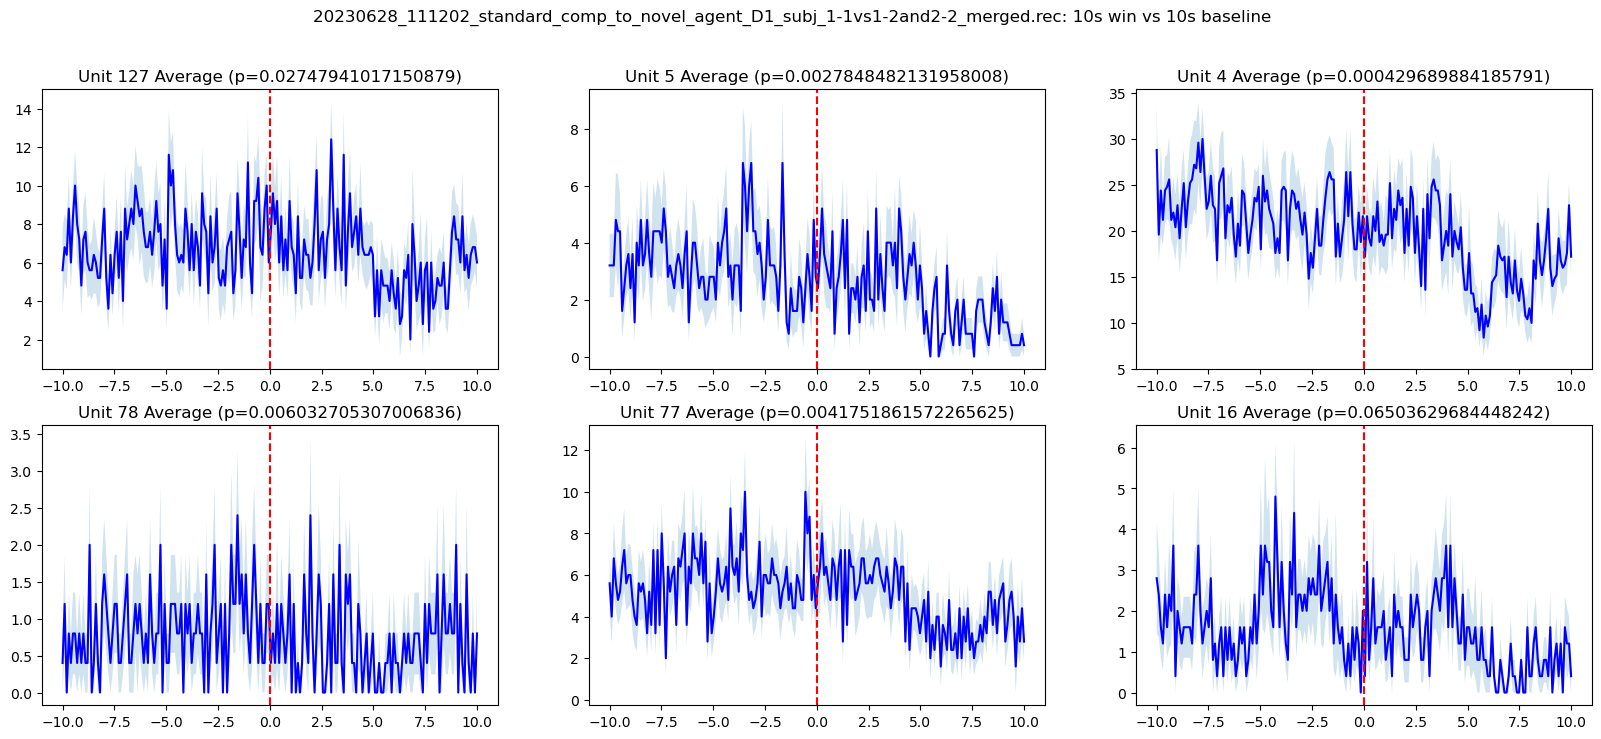

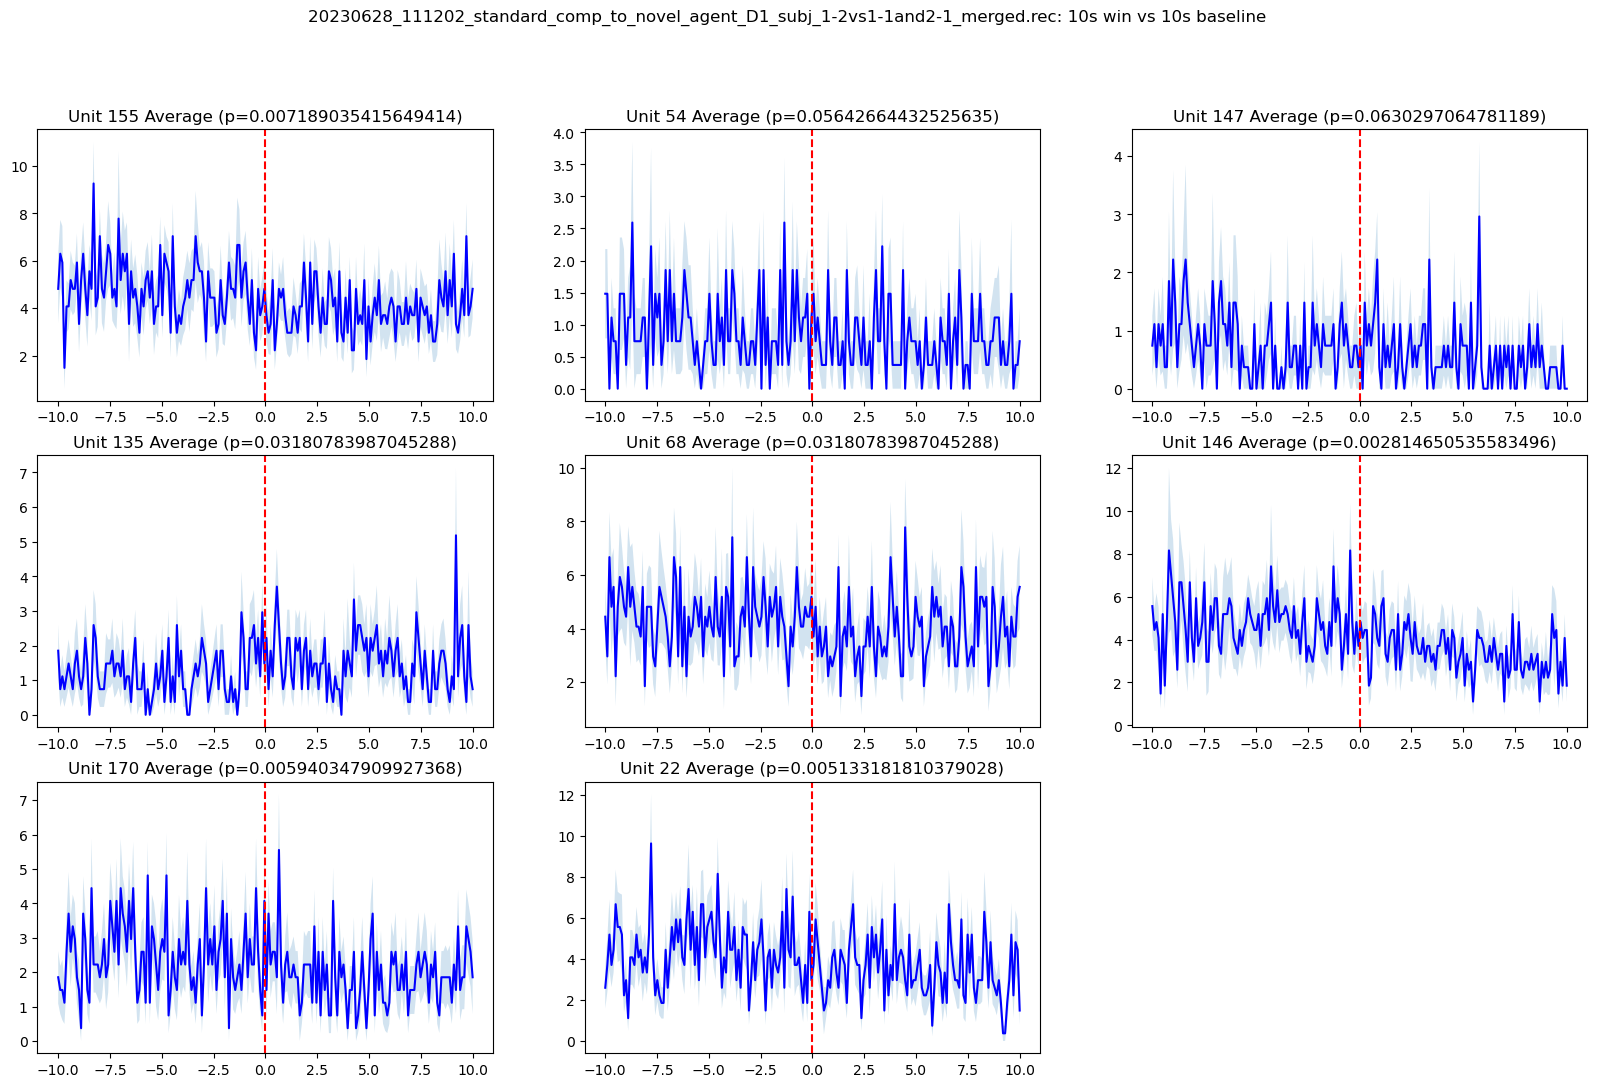

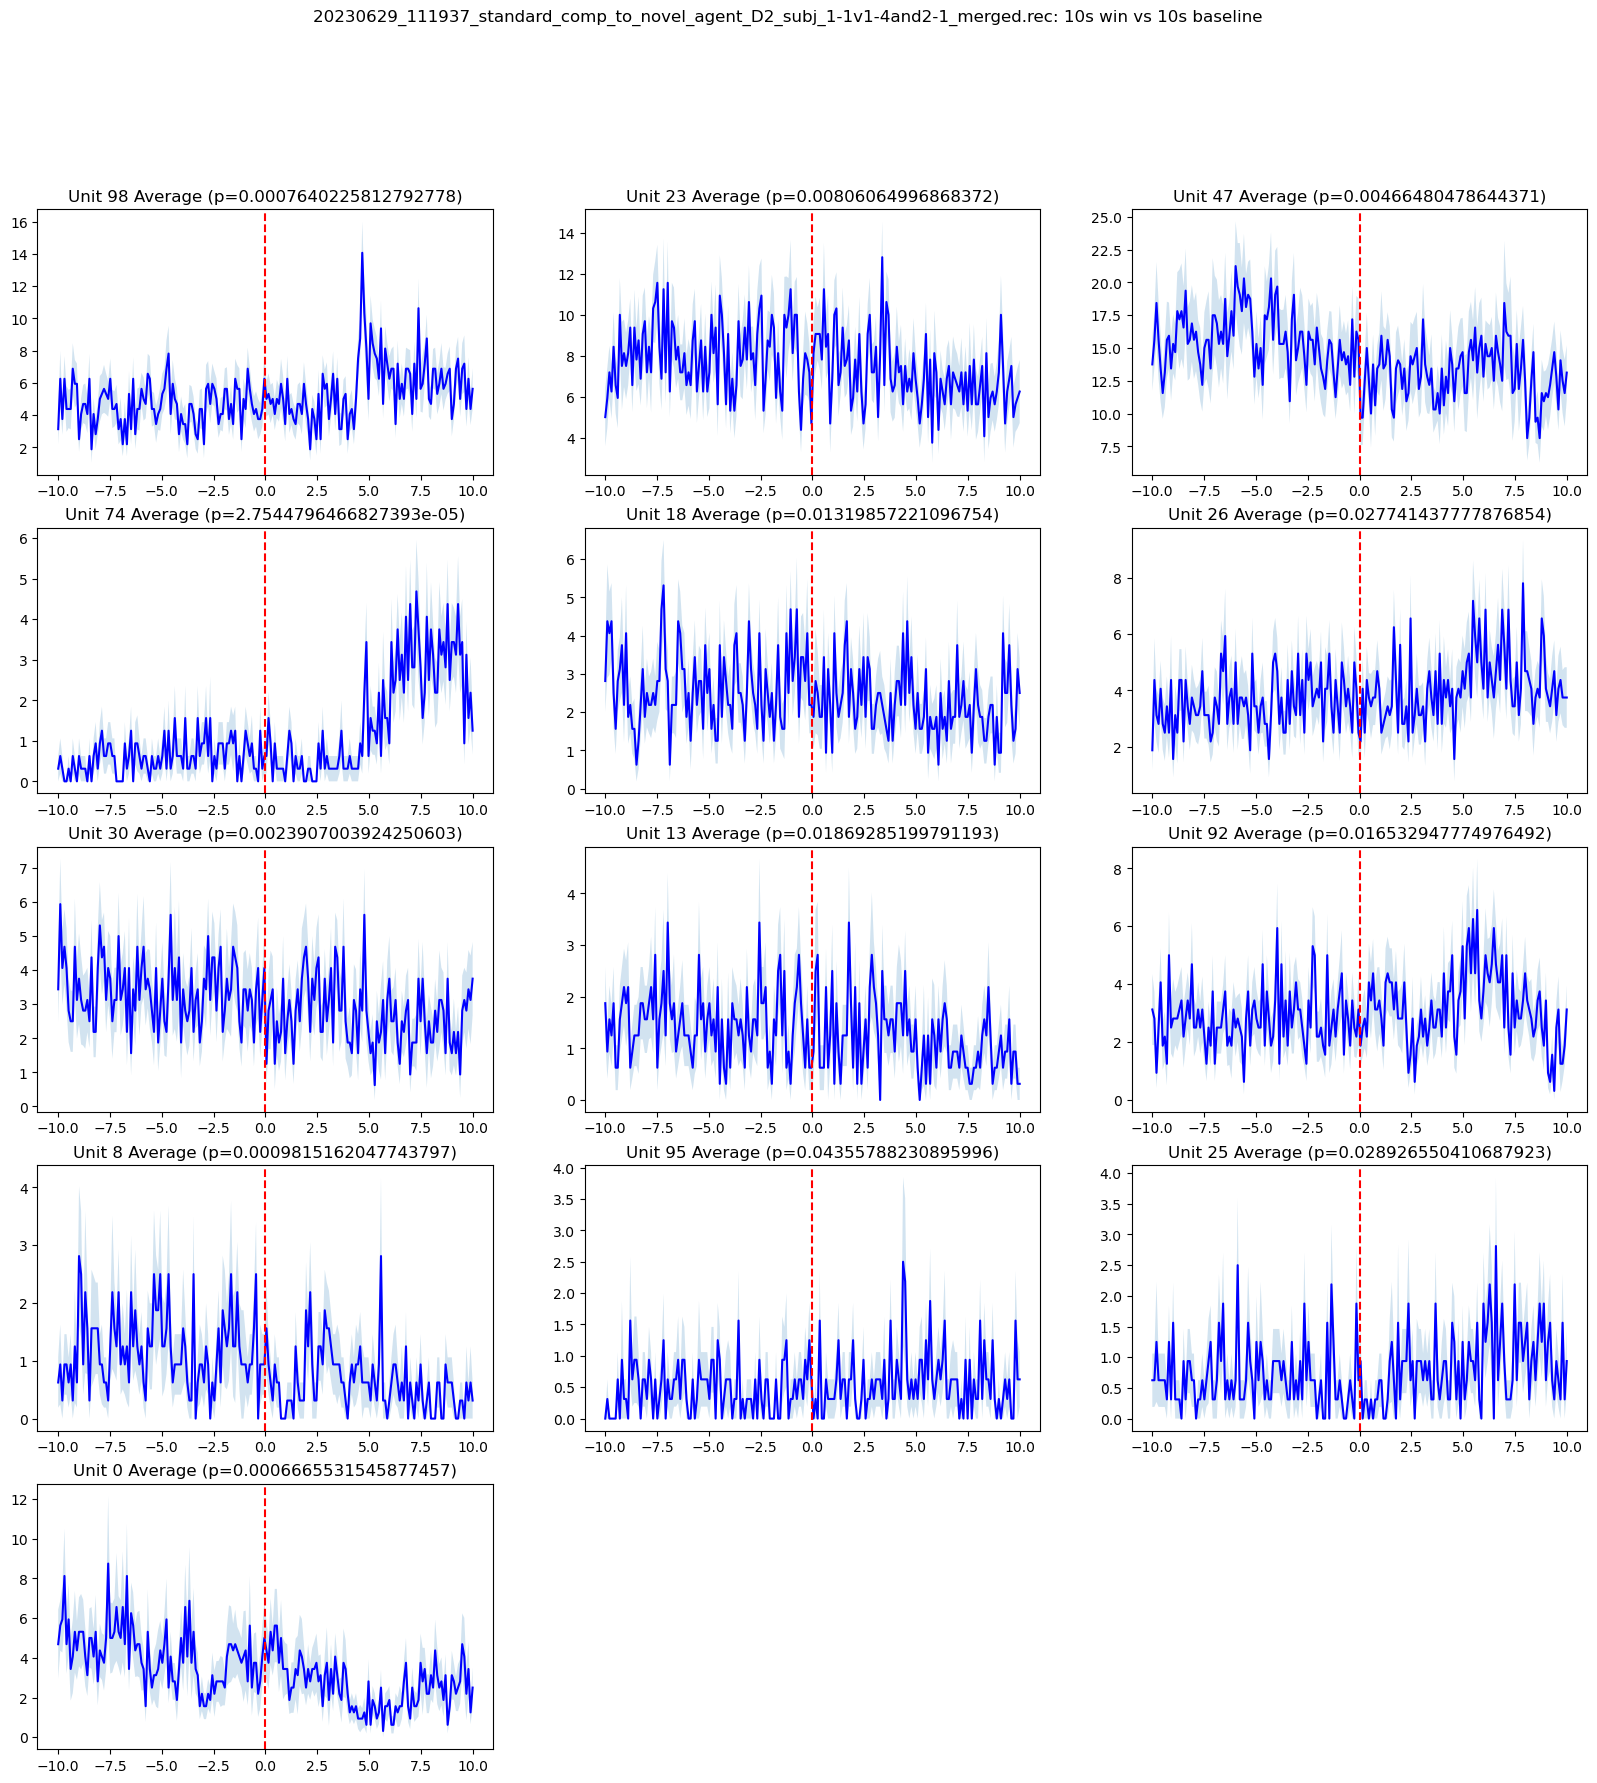

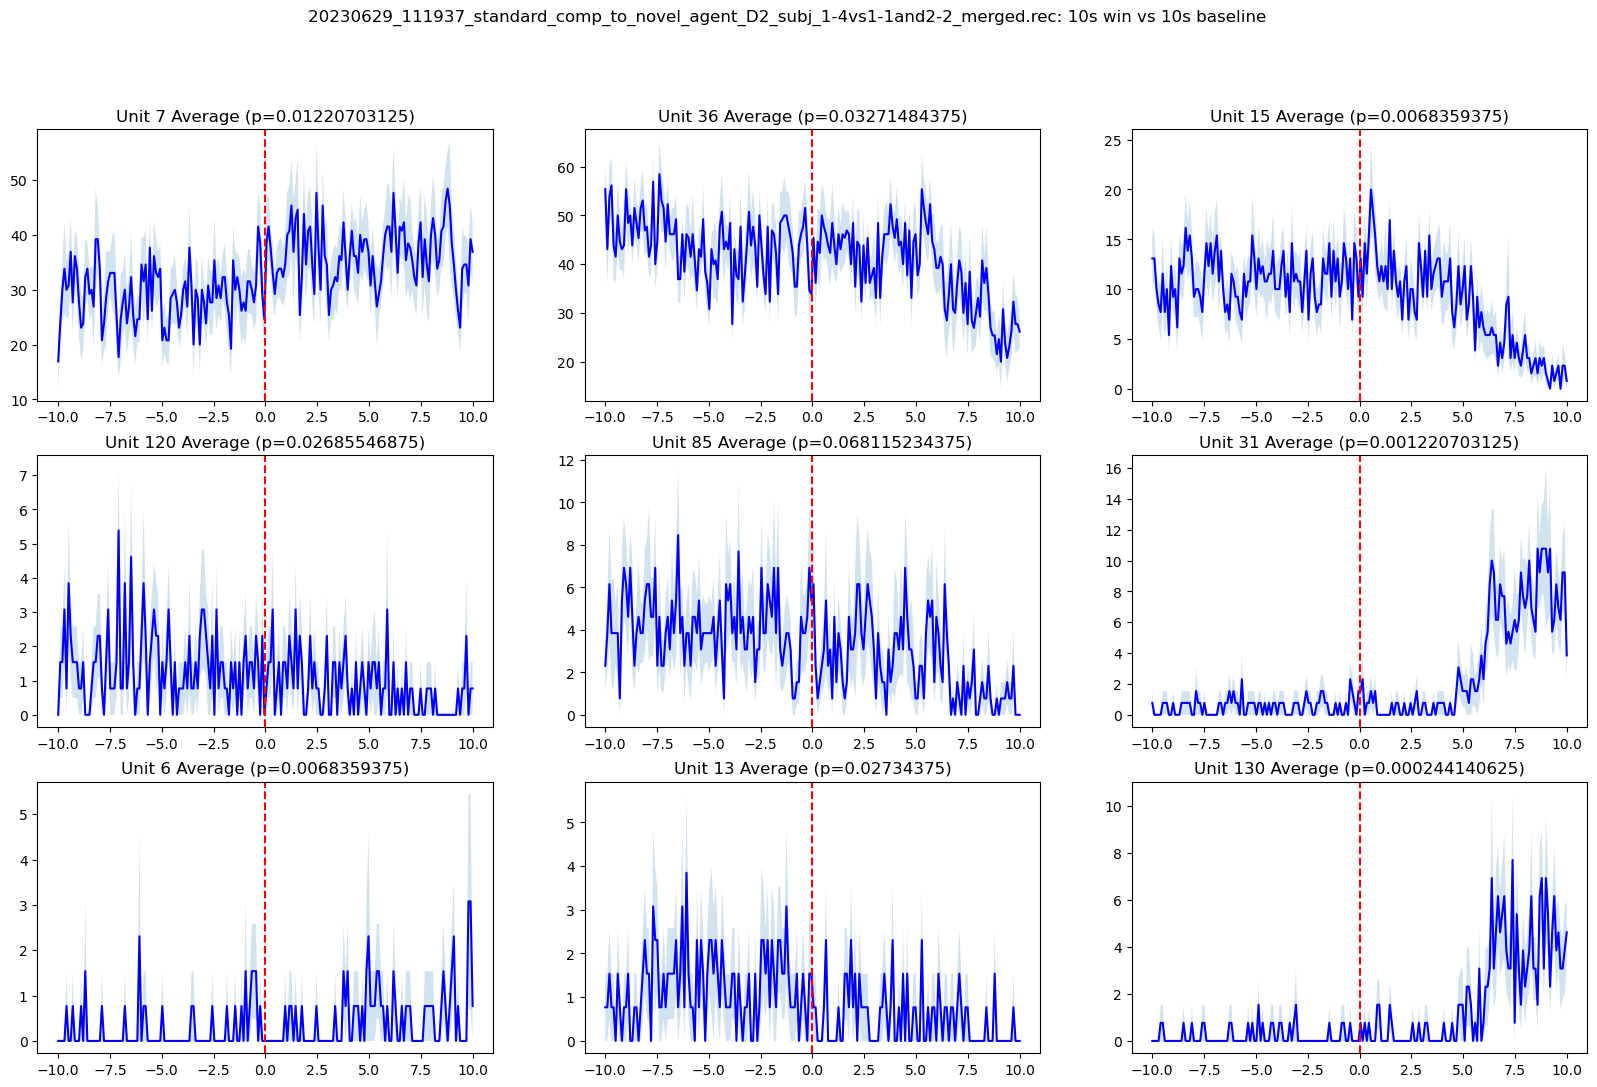

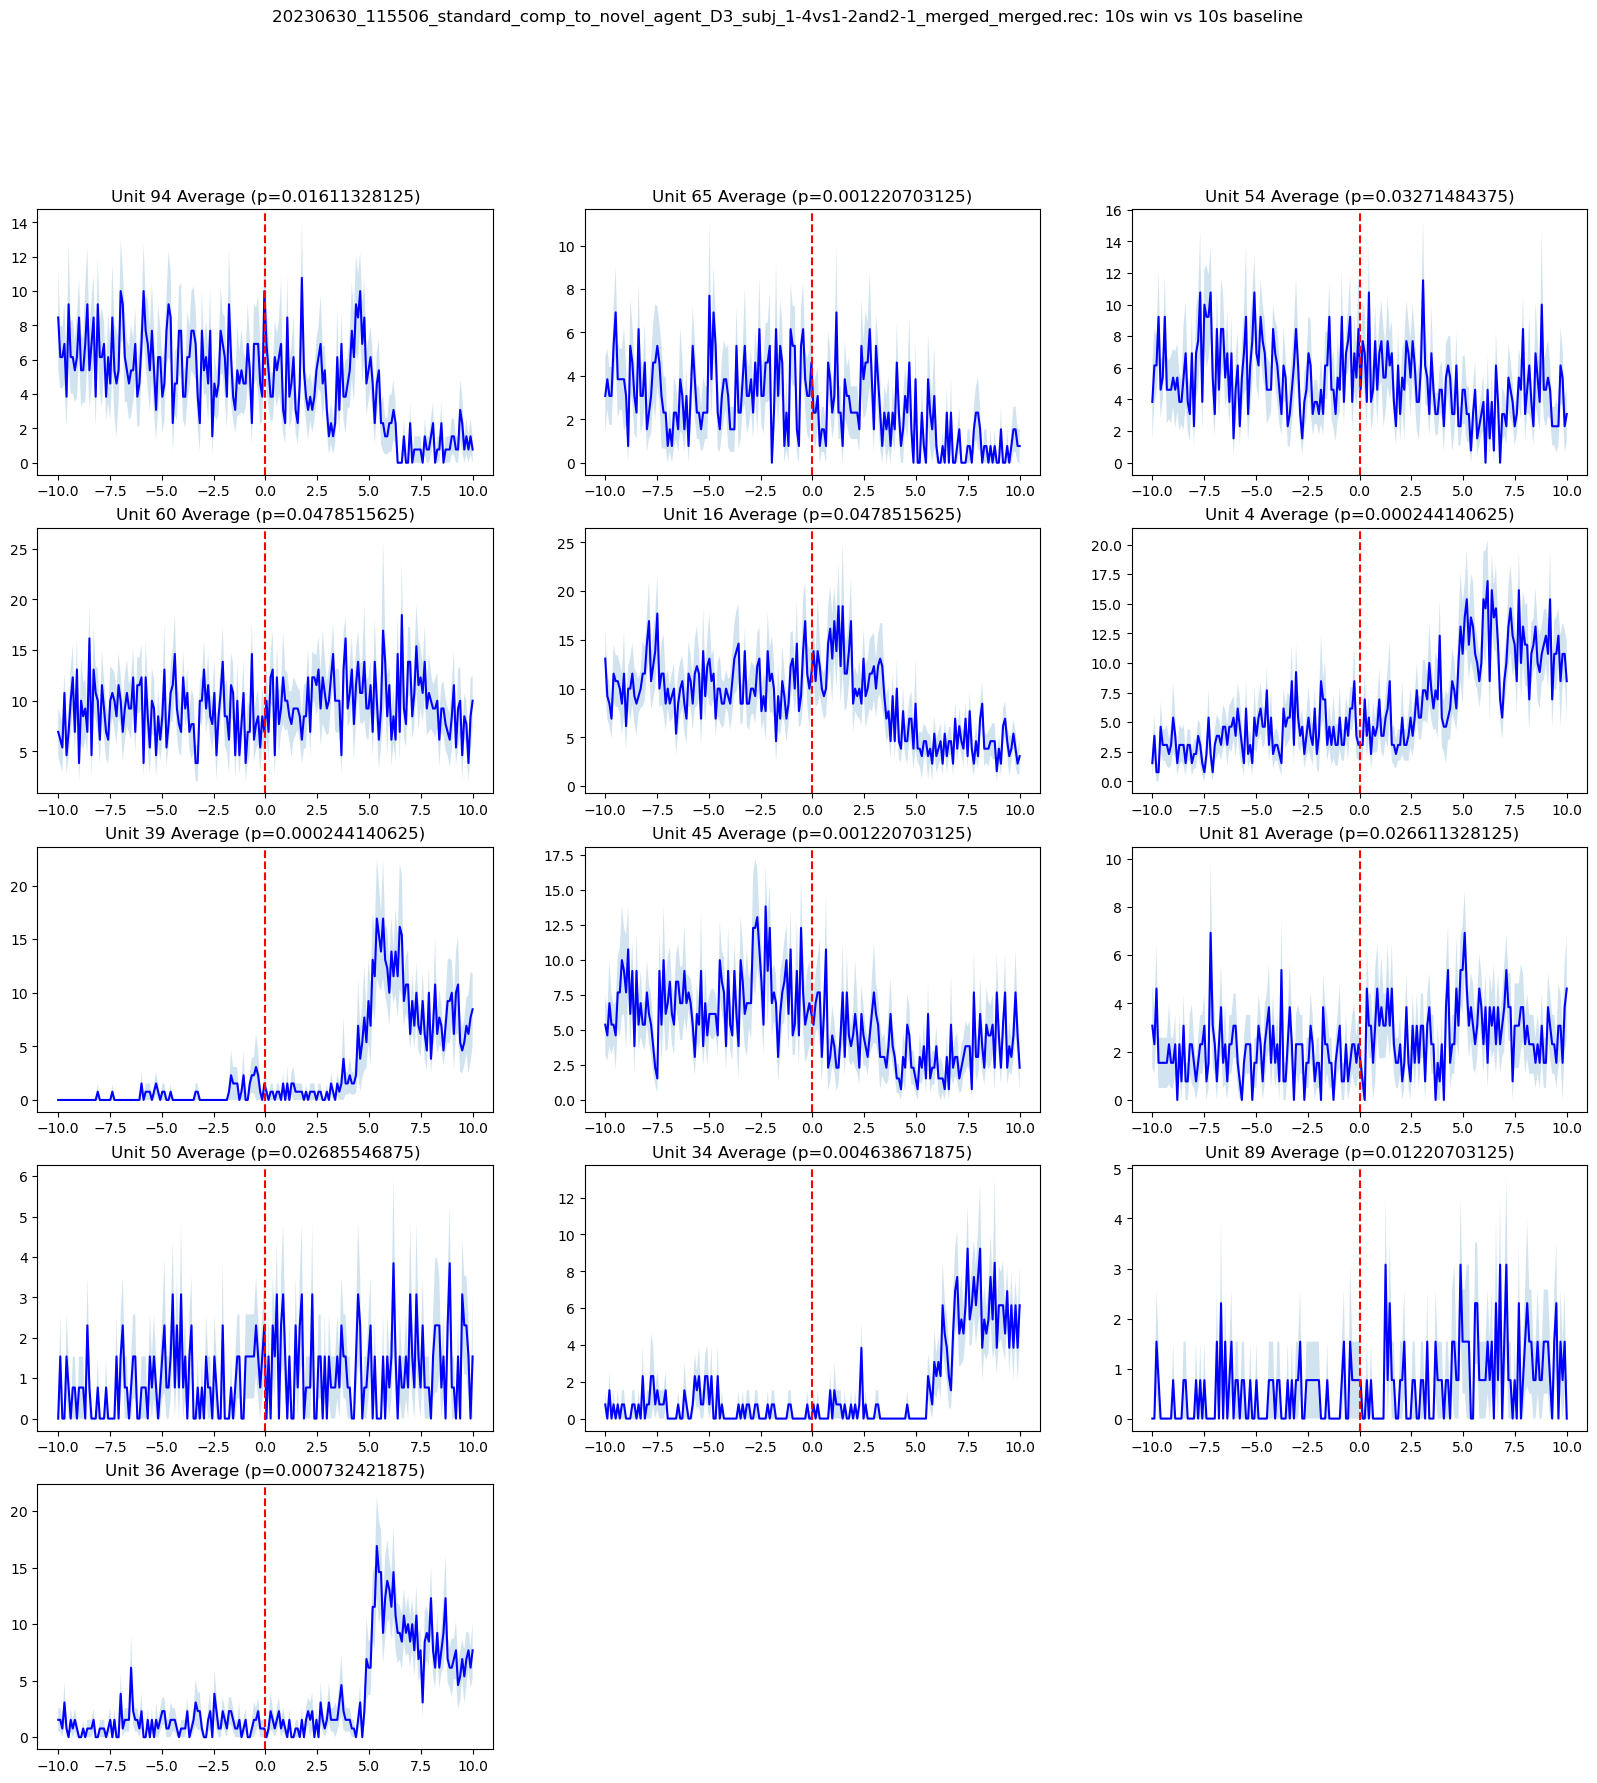

original unit id  Wilcoxon Stat   p value event1 vs event2  \
0                  20          108.0  0.148480  not significant   
1                 127           81.5  0.027479        increases   
2                  39          162.0  1.000000  not significant   
3                 106          143.5  0.855336  not significant   
4                   0          124.5  0.312333  not significant   
..                ...            ...       ...              ...   
127                15           44.0  0.946045  not significant   
128                89            7.5  0.012207        increases   
129                79           24.0  0.266113  not significant   
130                17           16.5  0.147461  not significant   
131                36            2.0  0.000732        increases   

                                             Recording Subject  \
0    20230628_111202_standard_comp_to_novel_agent_D...     1-1   
1    20230628_111202_standard_comp_to_novel_agent_D...     1-1   
2    20230628_111202_standard_comp_to_novel_agent_D...     1-1   
3    20230628_111202_standard_comp_to_novel_agent_D...     1-1   
4    20230628_111202_standard_comp_to_novel_agent_D...     1-1   
..                                                 ...     ...   
127  20230630_115506_standard_comp_to_novel_agent_D...     1-4   
128  20230630_115506_standard_comp_to_novel_agent_D...     1-4   
129  20230630_115506_standard_comp_to_novel_agent_D...     1-4   
130  20230630_115506_standard_comp_to_novel_agent_D...     1-4   
131  20230630_115506_standard_comp_to_novel_agent_D...     1-4   

                       Event  
0    10s win vs 10s baseline  
1    10s win vs 10s baseline  
2    10s win vs 10s baseline  
3    10s win vs 10s baseline  
4    10s win vs 10s baseline  
..                       ...  
127  10s win vs 10s baseline  
128  10s win vs 10s baseline  
129  10s win vs 10s baseline  
130  10s win vs 10s baseline  
131  10s win vs 10s baseline  

[132 rows x 7 columns]

In [13]:
spike_analysis.wilcox_baseline_v_event_collection("win", 10, 10)

<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject
All set to analyze
Wilcoxon can't be done on 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec win, because <6 samples


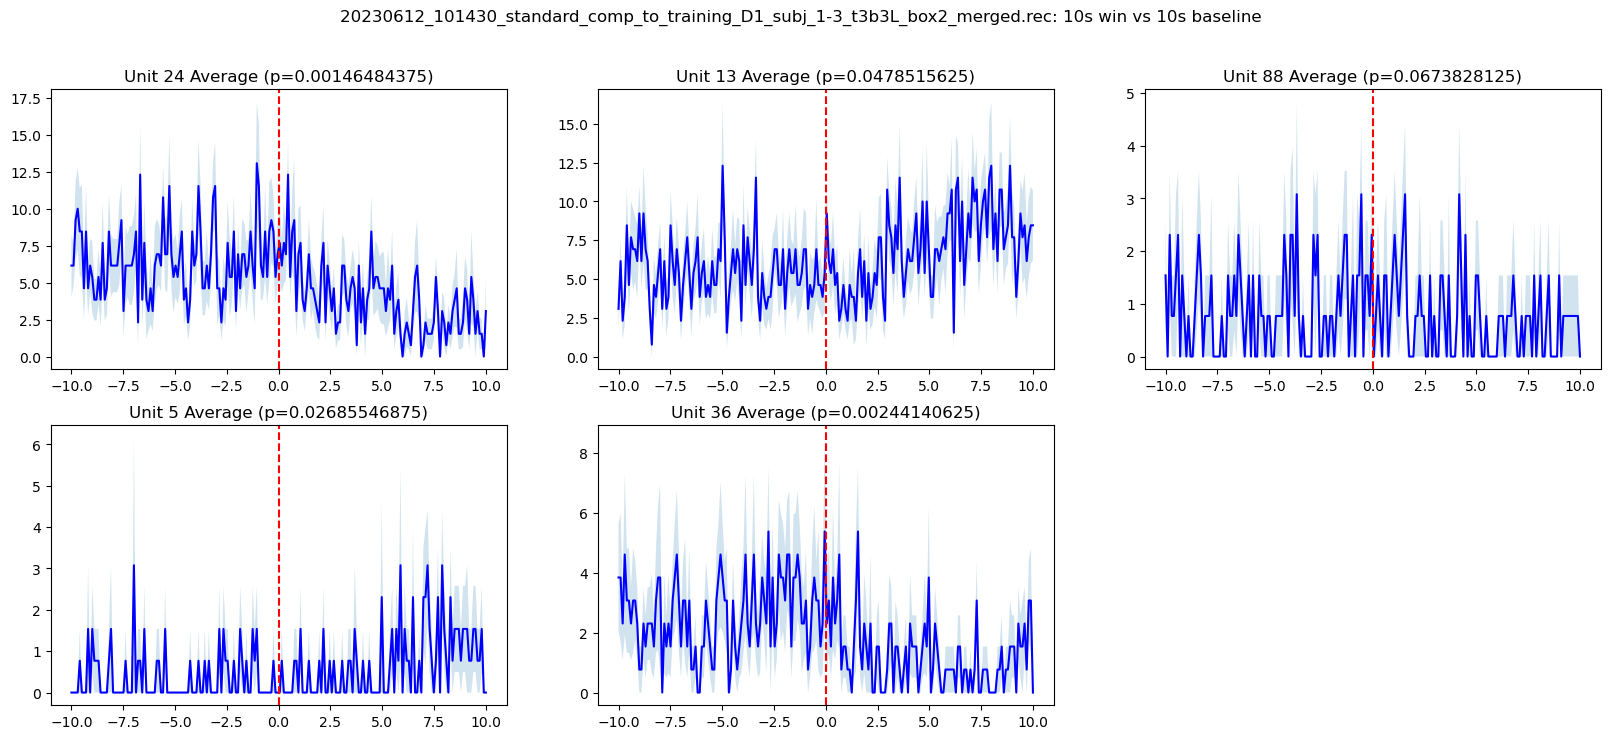

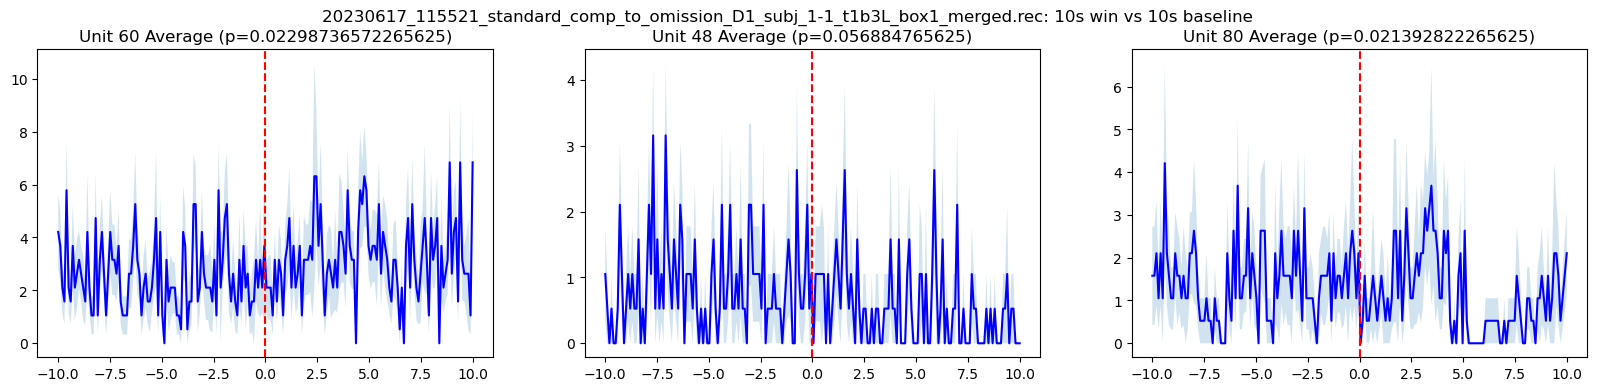

<Figure size 2000x0 with 0 Axes>

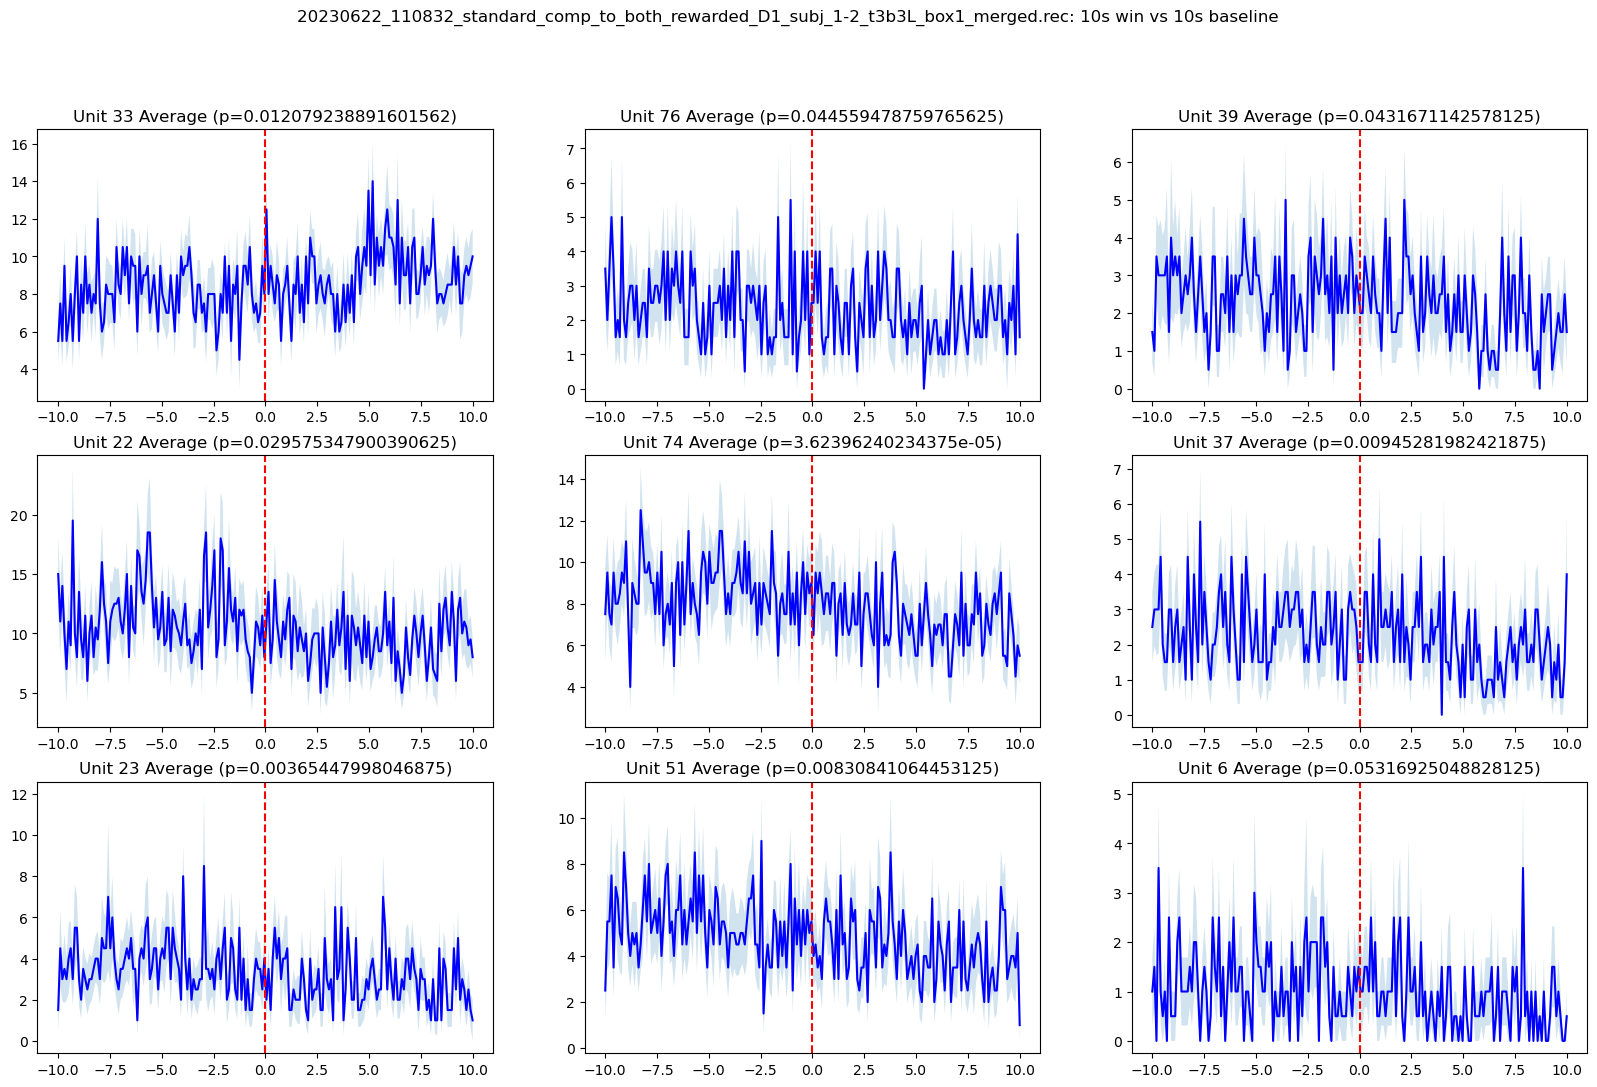

original unit id  Wilcoxon Stat   p value event1 vs event2  \
0                 85           38.0  0.969727  not significant   
1                 55           36.0  0.541748  not significant   
2                 17           29.0  0.469727  not significant   
3                 24            2.0  0.001465        increases   
4                 68           33.0  0.414307  not significant   
..               ...            ...       ...              ...   
59                55           74.0  0.639694  not significant   
60                27           58.0  0.403763  not significant   
61               102           76.0  0.294252  not significant   
62                 6           53.0  0.053169  not significant   
63                15           60.0  0.168793  not significant   

                                            Recording Subject  \
0   20230612_101430_standard_comp_to_training_D1_s...     1-3   
1   20230612_101430_standard_comp_to_training_D1_s...     1-3   
2   20230612_101430_standard_comp_to_training_D1_s...     1-3   
3   20230612_101430_standard_comp_to_training_D1_s...     1-3   
4   20230612_101430_standard_comp_to_training_D1_s...     1-3   
..                                                ...     ...   
59  20230622_110832_standard_comp_to_both_rewarded...     1-2   
60  20230622_110832_standard_comp_to_both_rewarded...     1-2   
61  20230622_110832_standard_comp_to_both_rewarded...     1-2   
62  20230622_110832_standard_comp_to_both_rewarded...     1-2   
63  20230622_110832_standard_comp_to_both_rewarded...     1-2   

                      Event  
0   10s win vs 10s baseline  
1   10s win vs 10s baseline  
2   10s win vs 10s baseline  
3   10s win vs 10s baseline  
4   10s win vs 10s baseline  
..                      ...  
59  10s win vs 10s baseline  
60  10s win vs 10s baseline  
61  10s win vs 10s baseline  
62  10s win vs 10s baseline  
63  10s win vs 10s baseline  

[64 rows x 7 columns]

In [14]:
import ast
from pathlib import Path

import multirecording_spikeanalysis as spike
import numpy as np
import pandas as pd

cols = [
    "condition ",
    "session_dir",
    "all_subjects",
    "tone_start_timestamp",
    "tone_stop_timestamp",
]

# Load the data
df = pd.read_excel(
    "rce_pilot_2_per_video_trial_labels.xlsx", usecols=cols, engine="openpyxl"
)

df2 = df.dropna()  # Drop the rows missing data
df3 = df2.copy()
df3["all_subjects"] = df3["all_subjects"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)  # Make the 'all_subjects' column readable as a list

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df3.iterrows():
    session_dir = row["session_dir"]
    subjects = row["all_subjects"]
    condition = row["condition "]

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split("_subj_")[0]

    for subject in subjects:
        subject_formatted = subject.replace(".", "-")
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append(
            {
                "session_dir": session_dir,
                "subject": subject,
                "subj_recording": subj_recording,
                "condition": (
                    condition
                    if condition in ["rewarded", "omission", "both_rewarded", "tie"]
                    else ("win" if str(condition) == str(subject) else "lose")
                ),
                "tone_start_timestamp": row["tone_start_timestamp"],
                "tone_stop_timestamp": row["tone_stop_timestamp"],
            }
        )

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row["subj_recording"]
    condition = row["condition"]
    timestamp_start = int(row["tone_start_timestamp"]) // 20
    timestamp_end = int(row["tone_stop_timestamp"]) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {
            cond: []
            for cond in ["rewarded", "win", "lose", "omission", "both_rewarded", "tie"]
        }
    if condition not in timestamp_dicts[key]:
        timestamp_dicts[key][condition] = []
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(
            timestamp_dicts[subj_recording][condition], dtype=np.int64
        )

# Handle novel sessions with more than 2 subjects
novel_sessions = df3[df3["all_subjects"].apply(lambda x: len(x) >= 3)]
novel_dicts = {}
for _, row in novel_sessions.iterrows():
    session_dir = row["session_dir"]
    subjects = row["all_subjects"]
    condition = row["condition "]

    base_session_dir = session_dir.split("_subj_")[0]
    for subject in subjects:
        subject_formatted = subject.replace(".", "-")
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        key = f"{subj_recording}_novel"
        timestamp_start = int(row["tone_start_timestamp"]) // 20
        timestamp_end = int(row["tone_stop_timestamp"]) // 20
        tuple_val = (timestamp_start, timestamp_end)

        if key not in novel_dicts:
            novel_dicts[key] = {
                cond: []
                for cond in [
                    "rewarded",
                    "win",
                    "lose",
                    "omission",
                    "both_rewarded",
                    "tie",
                ]
            }
        if condition not in novel_dicts[key]:
            novel_dicts[key][condition] = []
        novel_dicts[key][condition].append(tuple_val)

# Convert lists in novel_dicts to numpy arrays
for subj_recording in novel_dicts:
    for condition in novel_dicts[subj_recording]:
        novel_dicts[subj_recording][condition] = np.array(
            novel_dicts[subj_recording][condition], dtype=np.int64
        )

# Combine regular and novel dictionaries
timestamp_dicts.update(novel_dicts)

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path(".") / "recordings" / "updated_phys" / "test"

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find("subj_")
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len("subj_") + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[
            recording_key_without_suffix
        ]

        # Extract the subject from the recording key
        start = recording.find("subj_") + 5  # Start index after 'subj_'
        subject = recording[start : start + 3]

        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

spike_analysis = spike.SpikeAnalysis_MultiRecording(
    ephys_data, timebin=100, ignore_freq=0.5
)

spike_analysis.wilcox_baseline_v_event_collection("win", 10, 10)

<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject
All set to analyze
Wilcoxon can't be done on 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec win, because <6 samples


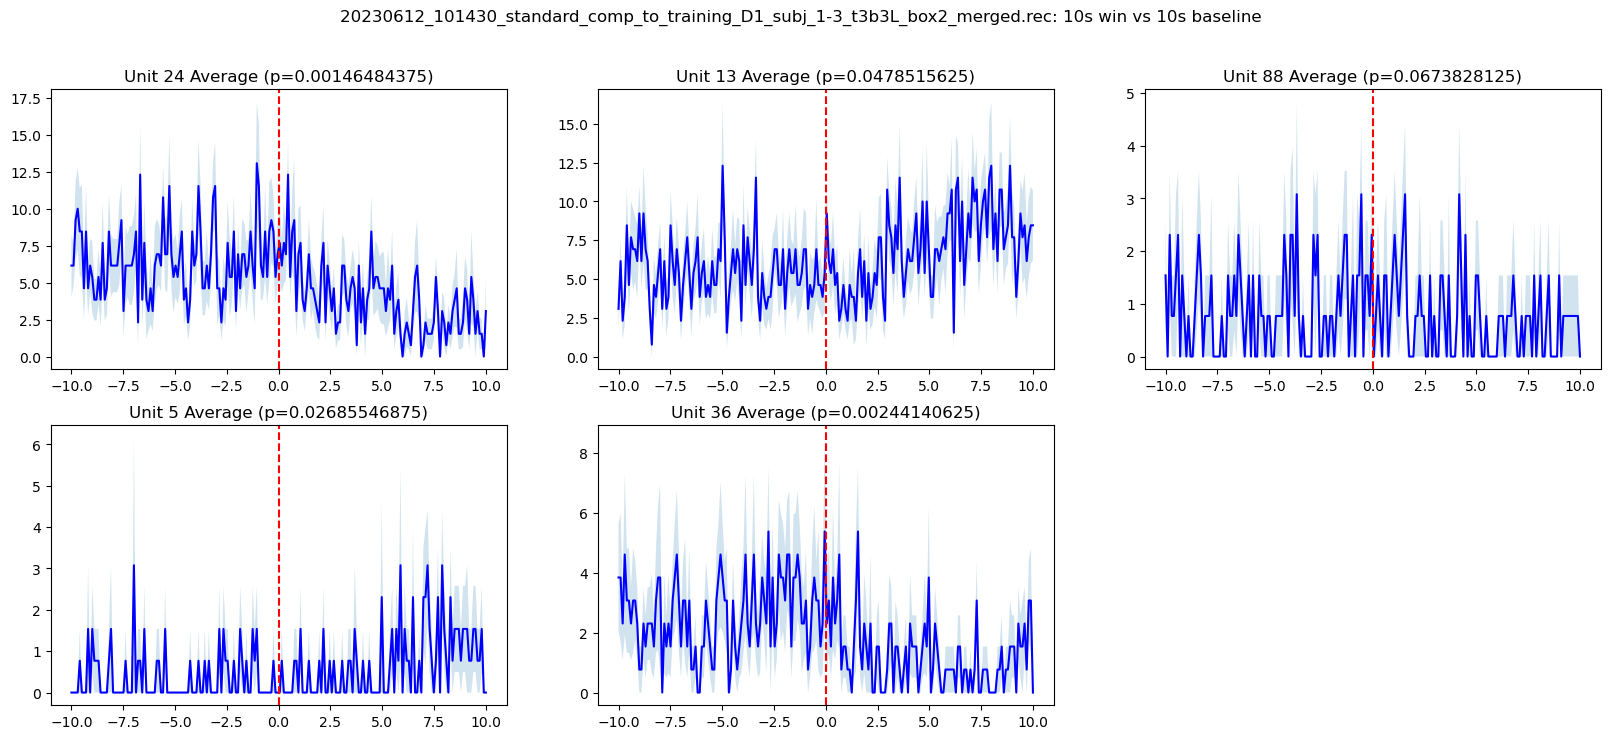

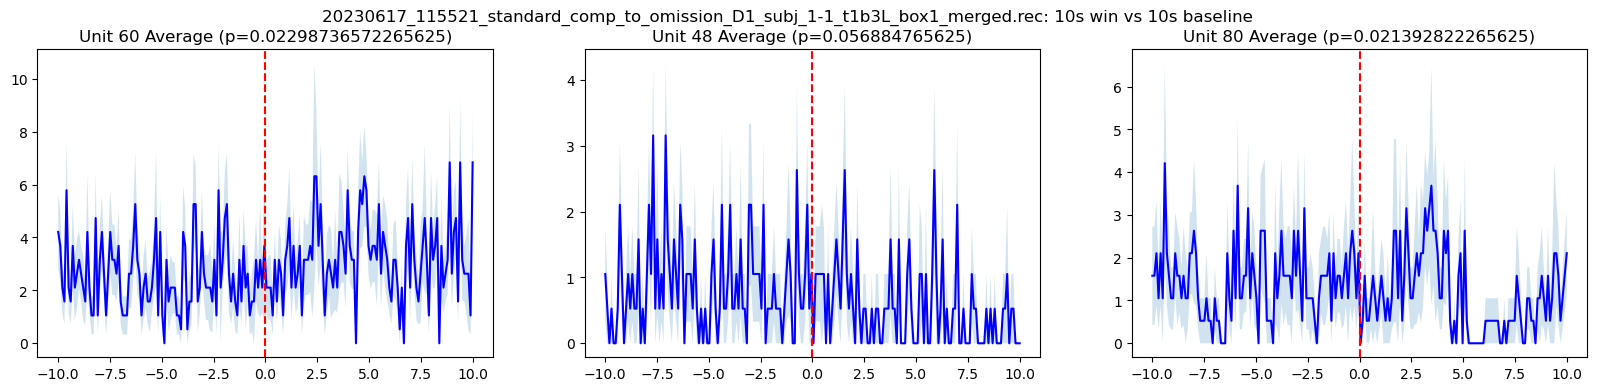

<Figure size 2000x0 with 0 Axes>

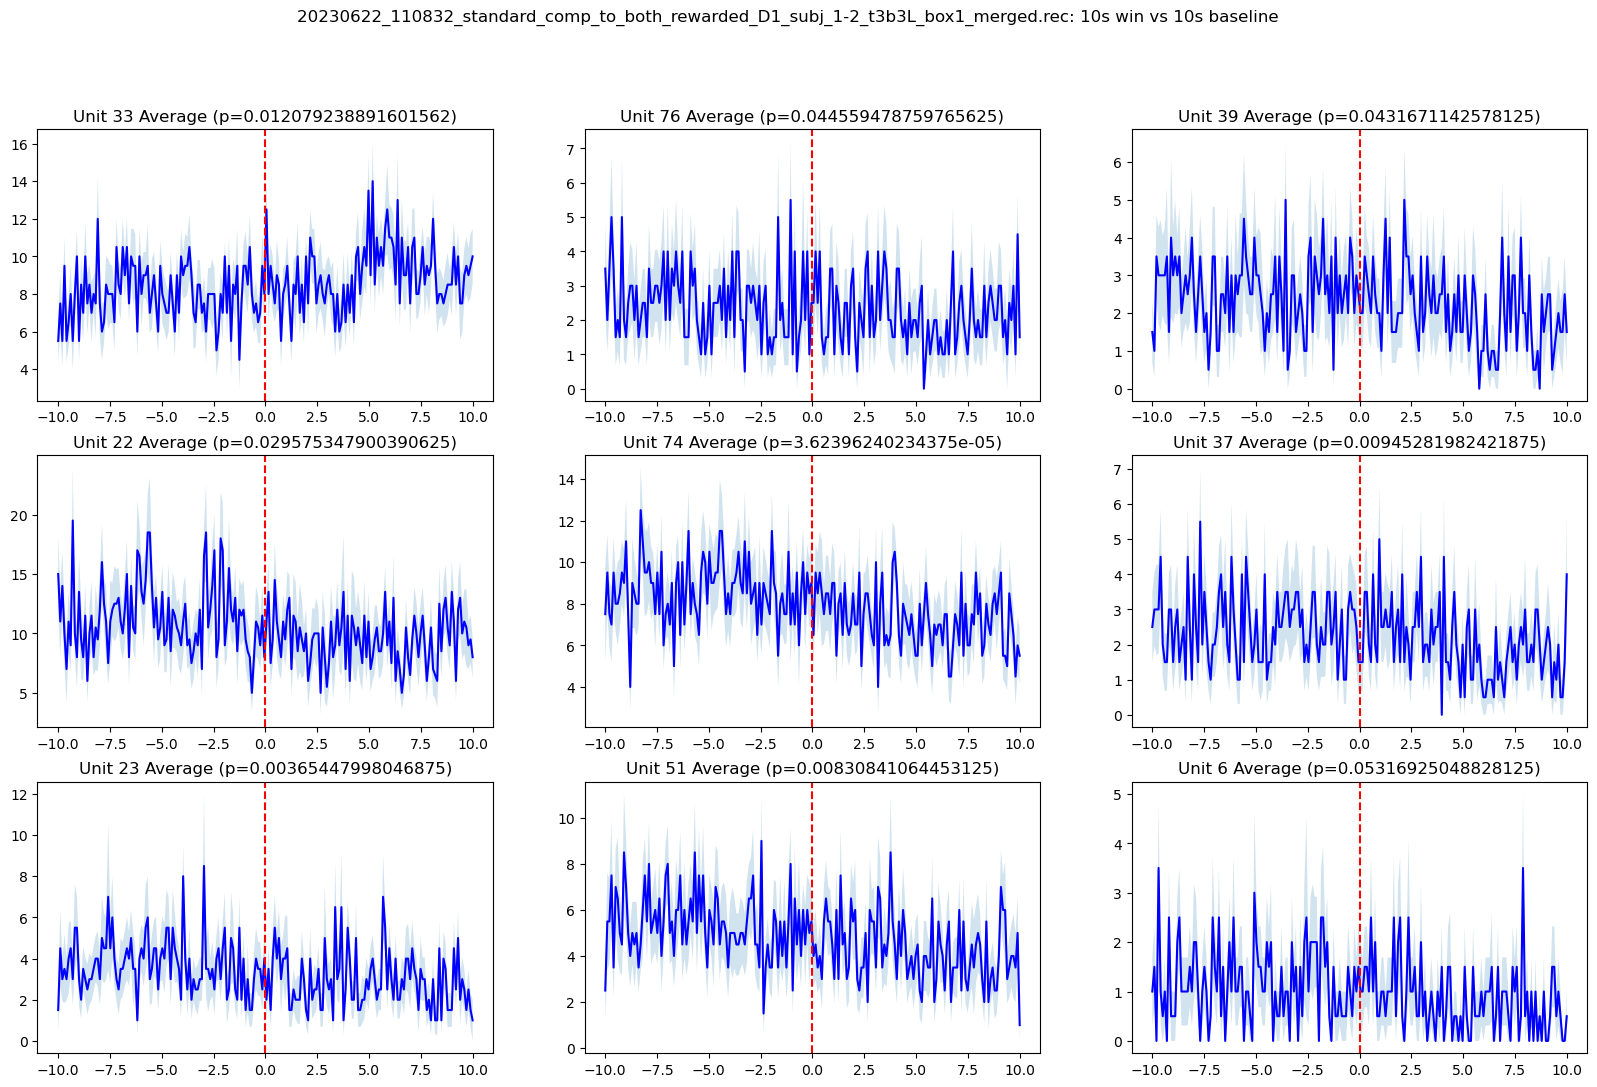

original unit id  Wilcoxon Stat   p value event1 vs event2  \
0                 85           38.0  0.969727  not significant   
1                 55           36.0  0.541748  not significant   
2                 17           29.0  0.469727  not significant   
3                 24            2.0  0.001465        increases   
4                 68           33.0  0.414307  not significant   
..               ...            ...       ...              ...   
59                55           74.0  0.639694  not significant   
60                27           58.0  0.403763  not significant   
61               102           76.0  0.294252  not significant   
62                 6           53.0  0.053169  not significant   
63                15           60.0  0.168793  not significant   

                                            Recording Subject  \
0   20230612_101430_standard_comp_to_training_D1_s...     1-3   
1   20230612_101430_standard_comp_to_training_D1_s...     1-3   
2   20230612_101430_standard_comp_to_training_D1_s...     1-3   
3   20230612_101430_standard_comp_to_training_D1_s...     1-3   
4   20230612_101430_standard_comp_to_training_D1_s...     1-3   
..                                                ...     ...   
59  20230622_110832_standard_comp_to_both_rewarded...     1-2   
60  20230622_110832_standard_comp_to_both_rewarded...     1-2   
61  20230622_110832_standard_comp_to_both_rewarded...     1-2   
62  20230622_110832_standard_comp_to_both_rewarded...     1-2   
63  20230622_110832_standard_comp_to_both_rewarded...     1-2   

                      Event  
0   10s win vs 10s baseline  
1   10s win vs 10s baseline  
2   10s win vs 10s baseline  
3   10s win vs 10s baseline  
4   10s win vs 10s baseline  
..                      ...  
59  10s win vs 10s baseline  
60  10s win vs 10s baseline  
61  10s win vs 10s baseline  
62  10s win vs 10s baseline  
63  10s win vs 10s baseline  

[64 rows x 7 columns]

In [15]:
import ast
from pathlib import Path

import multirecording_spikeanalysis as spike
import numpy as np
import pandas as pd

cols = [
    "condition ",
    "session_dir",
    "all_subjects",
    "tone_start_timestamp",
    "tone_stop_timestamp",
]

# Load the data
df = pd.read_excel(
    "rce_pilot_2_per_video_trial_labels.xlsx", usecols=cols, engine="openpyxl"
)

df2 = df.dropna()  # Drop the rows missing data
df3 = df2.copy()
df3["all_subjects"] = df3["all_subjects"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)  # Make the 'all_subjects' column readable as a list

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df3.iterrows():
    session_dir = row["session_dir"]
    subjects = row["all_subjects"]
    condition = row["condition "]

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split("_subj_")[0]

    for subject in subjects:
        subject_formatted = subject.replace(".", "-")
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append(
            {
                "session_dir": session_dir,
                "subject": subject,
                "subj_recording": subj_recording,
                "condition": (
                    condition
                    if condition in ["rewarded", "omission", "both_rewarded", "tie"]
                    else ("win" if str(condition) == str(subject) else "lose")
                ),
                "tone_start_timestamp": row["tone_start_timestamp"],
                "tone_stop_timestamp": row["tone_stop_timestamp"],
            }
        )

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row["subj_recording"]
    condition = row["condition"]
    timestamp_start = int(row["tone_start_timestamp"]) // 20
    timestamp_end = int(row["tone_stop_timestamp"]) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {
            cond: []
            for cond in ["rewarded", "win", "lose", "omission", "both_rewarded", "tie"]
        }
    if condition not in timestamp_dicts[key]:
        timestamp_dicts[key][condition] = []
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(
            timestamp_dicts[subj_recording][condition], dtype=np.int64
        )

# Handle novel sessions with more than 2 subjects
novel_sessions = df3[df3["all_subjects"].apply(lambda x: len(x) >= 3)]
novel_dicts = {}
for _, row in novel_sessions.iterrows():
    session_dir = row["session_dir"]
    subjects = row["all_subjects"]
    condition = row["condition "]

    base_session_dir = session_dir.split("_subj_")[0]
    for subject in subjects:
        subject_formatted = subject.replace(".", "-")
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        key = f"{subj_recording}_novel"
        timestamp_start = int(row["tone_start_timestamp"]) // 20
        timestamp_end = int(row["tone_stop_timestamp"]) // 20
        tuple_val = (timestamp_start, timestamp_end)

        if key not in novel_dicts:
            novel_dicts[key] = {
                cond: []
                for cond in [
                    "rewarded",
                    "win",
                    "lose",
                    "omission",
                    "both_rewarded",
                    "tie",
                ]
            }
        if condition not in novel_dicts[key]:
            novel_dicts[key][condition] = []
        novel_dicts[key][condition].append(tuple_val)

# Convert lists in novel_dicts to numpy arrays
for subj_recording in novel_dicts:
    for condition in novel_dicts[subj_recording]:
        novel_dicts[subj_recording][condition] = np.array(
            novel_dicts[subj_recording][condition], dtype=np.int64
        )

# Combine regular and novel dictionaries
timestamp_dicts.update(novel_dicts)

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path(".") / "recordings" / "updated_phys" / "test"

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find("subj_")
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len("subj_") + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[
            recording_key_without_suffix
        ]

        # Extract the subject from the recording key
        start = recording.find("subj_") + 5  # Start index after 'subj_'
        subject = recording[start : start + 3]

        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

spike_analysis = spike.SpikeAnalysis_MultiRecording(
    ephys_data, timebin=100, ignore_freq=0.5
)

spike_analysis.wilcox_baseline_v_event_collection("win", 10, 10)

In [16]:
from pathlib import Path

import multirecording_spikeanalysis as spike
import numpy as np
import pandas as pd

cols = [
    "condition ",
    "session_dir",
    "all_subjects",
    "tone_start_timestamp",
    "tone_stop_timestamp",
]
df = pd.read_excel(
    "rce_pilot_2_per_video_trial_labels.xlsx", usecols=cols, engine="openpyxl"
)
df.dropna(inplace=True)
df["all_subjects"] = df["all_subjects"].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

new_df_data = []
for _, row in df.iterrows():
    base_session_dir = row["session_dir"].split("_subj_")[0]
    for subject in row["all_subjects"]:
        subject_formatted = subject.replace(".", "-")
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        condition = row["condition "]
        if condition not in ["rewarded", "omission", "both_rewarded", "tie"]:
            condition = "win" if str(condition) == str(subject) else "lose"
        new_df_data.append(
            {
                "session_dir": row["session_dir"],
                "subject": subject,
                "subj_recording": subj_recording,
                "condition": condition,
                "tone_start_timestamp": row["tone_start_timestamp"],
                "tone_stop_timestamp": row["tone_stop_timestamp"],
            }
        )

new_df = pd.DataFrame(new_df_data)
timestamp_dicts = {}
for _, row in new_df.iterrows():
    start = int(row["tone_start_timestamp"]) // 20
    end = int(row["tone_stop_timestamp"]) // 20
    key = row["subj_recording"]
    condition = row["condition"]
    if key not in timestamp_dicts:
        timestamp_dicts[key] = {}
    if condition not in timestamp_dicts[key]:
        timestamp_dicts[key][condition] = []
    timestamp_dicts[key][condition].append((start, end))

for key in timestamp_dicts:
    for condition in timestamp_dicts[key]:
        timestamp_dicts[key][condition] = np.array(
            timestamp_dicts[key][condition], dtype=np.int64
        )

ephys_path = Path("recordings/updated_phys/test")

ephys_data = spike.EphysRecordingCollection(str(ephys_path))
for recording in ephys_data.collection.keys():
    recording_key = recording[: recording.find("_subj_") + 8]
    if recording_key in timestamp_dicts:
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key]
        subject = recording.split("_subj_")[1][:3]
        ephys_data.collection[recording].subject = subject

spike_analysis = spike.SpikeAnalysis_MultiRecording(
    ephys_data, timebin=100, ignore_freq=0.5
)

spike_analysis.wilcox_baseline_v_event_collection("win", 10, 10)

<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject
These recordings are missing event dictionaries:
['20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec', '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec', '20230622_110832_standard_comp_to_both_rewarded_D1_sub

AttributeError: 'EphysRecording' object has no attribute 'event_dict'

In [17]:
print("Keys in timestamp_dicts:", list(timestamp_dicts.keys()))
print("Keys in ephys_data.collection:", [r for r in ephys_data.collection.keys()])

Keys in timestamp_dicts: ['20230612_101430_standard_comp_to_training_D1_subj_1-3', '20230612_101430_standard_comp_to_training_D1_subj_1-4', '20230612_112630_standard_comp_to_training_D1_subj_1-1', '20230612_112630_standard_comp_to_training_D1_subj_1-2', '20230613_105657_standard_comp_to_training_D2_subj_1-1', '20230613_105657_standard_comp_to_training_D2_subj_1-4', '20230614_114041_standard_comp_to_training_D3_subj_1-1', '20230614_114041_standard_comp_to_training_D3_subj_1-2', '20230616_111904_standard_comp_to_training_D4_subj_1-2', '20230616_111904_standard_comp_to_training_D4_subj_1-4', '20230617_115521_standard_comp_to_omission_D1_subj_1-1', '20230617_115521_standard_comp_to_omission_D1_subj_1-2', '20230618_100636_standard_comp_to_omission_D2_subj_1-1', '20230618_100636_standard_comp_to_omission_D2_subj_1-4', '20230619_115321_standard_comp_to_omission_D3_subj_1-2', '20230619_115321_standard_comp_to_omission_D3_subj_1-4', '20230620_114347_standard_comp_to_omission_D4_subj_1-1', '2023

In [18]:
for recording in ephys_data.collection.keys():
    # Extract a simplified key that should correspond to keys in timestamp_dicts
    simplified_key = recording.split("_subj_")[0]
    # Check if the simplified key exists in timestamp_dicts
    if simplified_key in timestamp_dicts:
        ephys_data.collection[recording].event_dict = timestamp_dicts[simplified_key]
    else:
        # Log missing keys and assign an empty dictionary
        print(f"Missing event_dict for recording: {recording}")
        ephys_data.collection[recording].event_dict = {}
    # Also ensure subject is assigned
    subject_marker = "subj_"
    start = recording.find(subject_marker) + len(subject_marker)
    end = start + 3  # Assuming subject identifiers are three characters long
    ephys_data.collection[recording].subject = recording[start:end]

Missing event_dict for recording: 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
Missing event_dict for recording: 20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
Missing event_dict for recording: 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
Missing event_dict for recording: 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec


In [19]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find("subj_")
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len("subj_") + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[
            recording_key_without_suffix
        ]

        # Extract the subject from the recording key
        start = recording.find("subj_") + 5  # Start index after 'subj_'
        subject = recording[start : start + 3]

        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
    else:
        # Log missing keys and assign an empty dictionary
        print(f"Missing event_dict for recording: {recording}")
        ephys_data.collection[recording].event_dict = {}

## Rows are specific to videos/cameras, not whole recording, so for a condition being "1.2", it isn't super clear who was competing

### In "20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.1.videoTimeStamps.cameraHWSync" the '.1.v' tells me it is camera one